# Series analysis


Analysis updates:
- retrieve calls rejected only because VAF<0.01 (bcbio lower acceptable threshold) for Mutect2, Strelka2 and Vardict
- correct for germline mutations using GATK haplotype calls
- get PR curves for sinvict by encoding the 6 files as thresholds. Assumption: linear filters
- plotting: PR curves stops at 10e-2 on the left
- ground truths:

    1) Consensus: build using
        majority of 5/8 callers for SNV and 3/5 callers for INDELS


    2) Ranked mutations: metascore built using
        weigthed sum of normalised scores between 0 and 1 for each caller
        with weigths = inversially proportional to number of calls made by caller (if a caller calls few mutations higher weight, it many calls low weight)
        threshold = 1/ncallers
        interpretation: if 1 caller is sure (score = 1) of calling this position, add it to GT
        interpretation: if 2 callers are quite sure of calling this position (score > 0,5 each), add it to GT
        
- integrate VAF approx

    1) mixture with VAF instead of tumor burden
    
    2) correct for mutations non present in diluted samples (vaf = 0)
    
    3) pool patients together using VAF

In [1]:
# Imports

%load_ext autoreload
%autoreload 2

import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
import warnings
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix

# set working directory
if not os.getcwd().endswith('cfdna_snv_benchmark'):
    os.chdir('../')
print('Current working directory: {}'.format(os.getcwd()))

from utils.config import Config
from utils.viz import *
from benchmark.table import *
from benchmark.metrics import *
from benchmark.calltable import *
from benchmark.calltableseries import *
from benchmark.groundtruth import *
from benchmark.metricsseries import *
#from utils.venn import venn6, get_labels

Current working directory: /Users/hanae/Repositories/cfdna_snv_benchmark


In [2]:
# Config and Display paramaters

config = Config("config/", "config_viz.yaml")
set_display_params(config)
print(config.methods)

paper
['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'smurf', 'varnet', 'abemus', 'sinvict']


In [166]:
# Chomosome

mixtureids =  ['CRC-986_100215-CW-T_CRC-986_300316-CW-T', 'CRC-1014_180816-CW-T_CRC-1014_090516-CW-T', 'CRC-123_310715-CW-T_CRC-123_121115-CW-T', 'BRA-412_240820-CW-T_BRA-412_060220-CW-T']
mixtureid = 'CRC-986_100215-CW-T_CRC-986_300316-CW-T'
#mixtureid = 'CRC-1014_180816-CW-T_CRC-1014_090516-CW-T'
#mixtureid = 'CRC-123_310715-CW-T_CRC-123_121115-CW-T'
#mixtureid = 'BRA-412_240820-CW-T_BRA-412_060220-CW-T'
reload = False
save = False
fixedvars=['coverage', 'ctdna']
filterparam = 'all'

markers = ['o', '^', 'X']
linestyles = ['-', '-', '-']
color_dict = {config.methods[i]: config.colors[i] for i in range(len(config.methods))}

muttypes = ['snv', 'indel']
metrics = ['auprc', 'precision', 'recall']

chrom = 'all'

# INDELS: patient 986 = 96, patient 123 = 357, patient 1014 = 277 (≥ 4/6 callers without SMURF)

# Part I: (1) Load/Generate call tables, (2) Generate Ground truths and (3) Compute/Save metrics per patient

############# CRC-986_100215-CW-T_CRC-986_300316-CW-T ############
mixture ['data', 'mixtures']
['3', '4', '5', '6', '7', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
['mixture_chr3_CRC-986_100215-CW-T_70x_CRC-986_300316-CW-T_0x', 'mixture_chr3_CRC-986_100215-CW-T_70x_CRC-986_300316-CW-T_80x', 'mixture_chr3_CRC-986_100215-CW-T_50x_CRC-986_300316-CW-T_100x', 'mixture_chr3_CRC-986_100215-CW-T_70x_CRC-986_300316-CW-T_180x', 'mixture_chr3_CRC-986_100215-CW-T_30x_CRC-986_300316-CW-T_120x', 'mixture_chr3_CRC-986_100215-CW-T_20x_CRC-986_300316-CW-T_130x', 'mixture_chr3_CRC-986_100215-CW-T_10x_CRC-986_300316-CW-T_140x', 'mixture_chr3_CRC-986_100215-CW-T_5x_CRC-986_300316-CW-T_145x']
['mixture_chr4_CRC-986_100215-CW-T_70x_CRC-986_300316-CW-T_0x', 'mixture_chr4_CRC-986_100215-CW-T_70x_CRC-986_300316-CW-T_80x', 'mixture_chr4_CRC-986_100215-CW-T_50x_CRC-986_300316-CW-T_100x', 'mixture_chr4_CRC-986_100215-CW-T_70x_CRC-986_300316-CW-T_180x', 'mixture_chr4_CRC-986_100215-CW-T_30x_

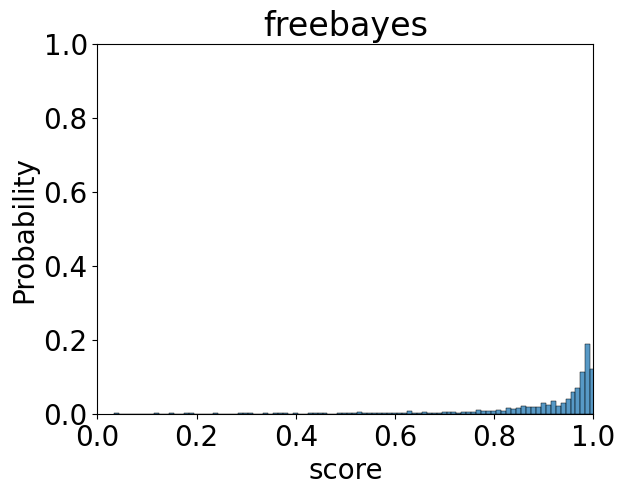

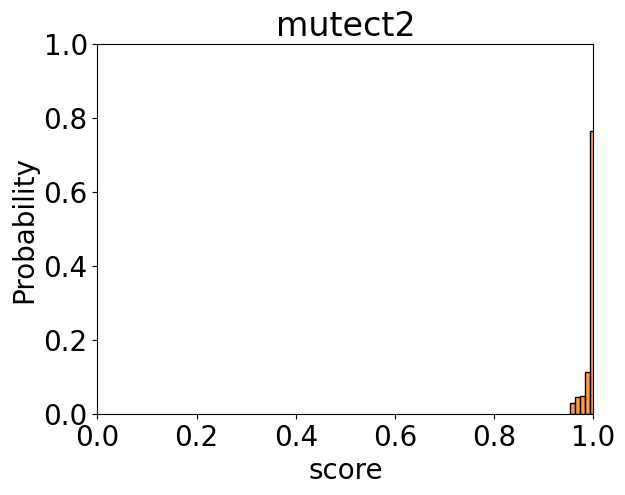

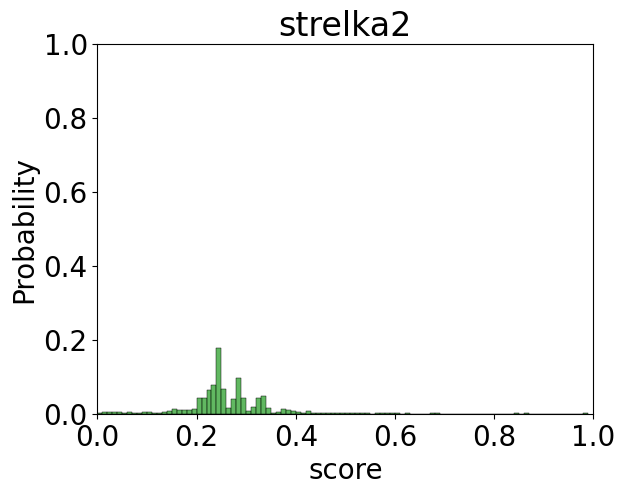

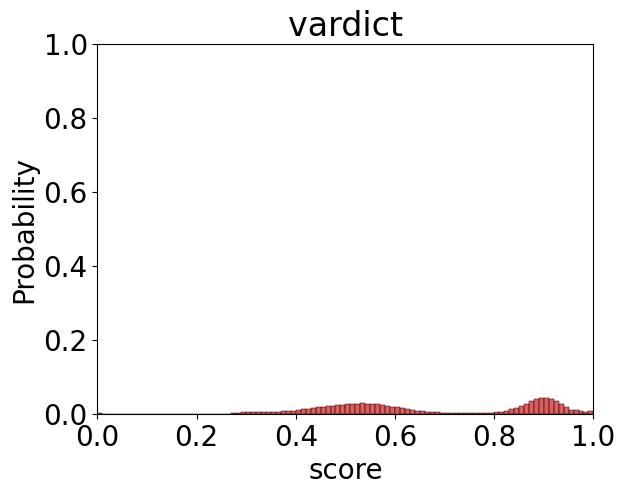

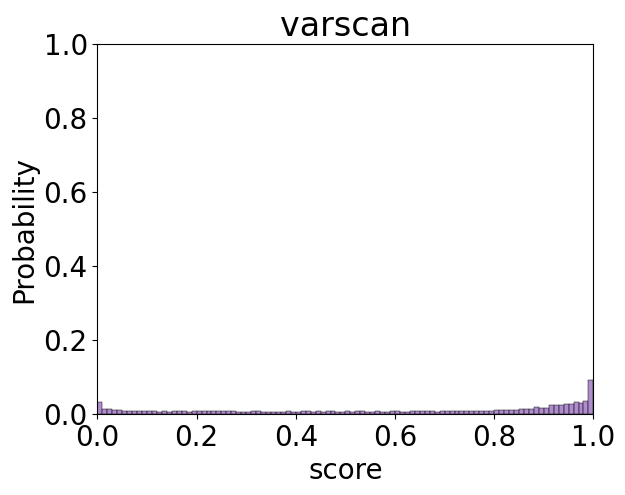

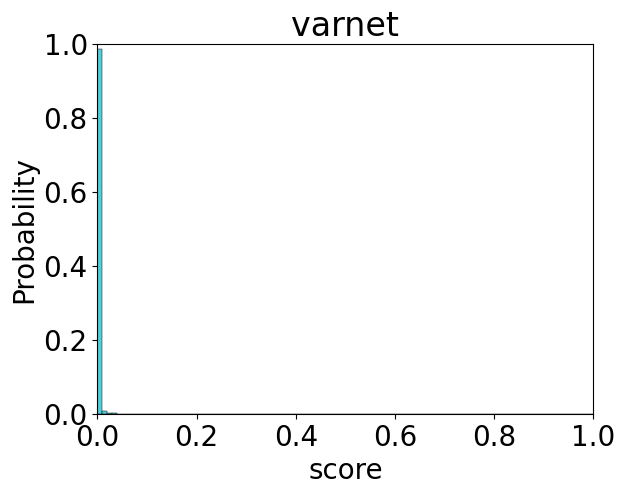

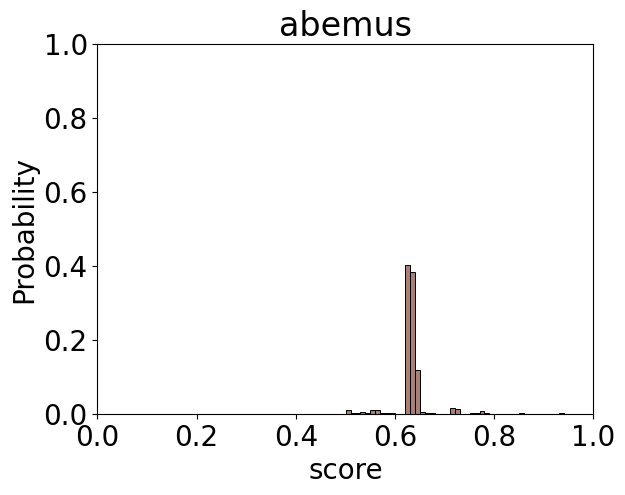

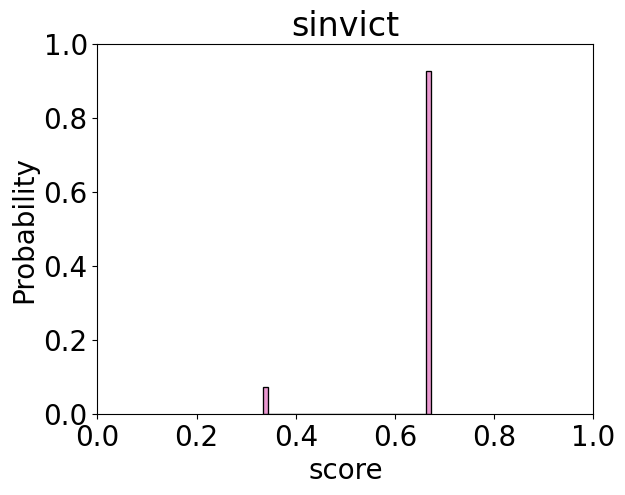

In [167]:
fixedvar = 'coverage'
#for fixedvar in fixedvars:
if fixedvar == 'coverage':
    seriesorder = [(70, 0), (70, 80), (50, 100), (30, 120), (20, 130), (10, 140), (5, 145)]
    xaxis = 'tumor burden'
elif fixedvar == 'ctdna':
    seriesorder = [(70, 0), (70, 80), (70, 180)]
    xaxis = 'coverage'

print('############# {} ############'.format(mixtureid))
if mixtureid ==  'CRC-1014_180816-CW-T_CRC-1014_090516-CW-T':
    chroms = [str(c) for c in range(1,23) if c != 2 and c!=6 and c !=17 and c!=19 and c!=20 and c!=21]
    #chroms = [str(c) for c in range(1,9) if c != 2 and c!=6]
elif mixtureid ==  'CRC-986_100215-CW-T_CRC-986_300316-CW-T':
    chroms = [str(c) for c in range(1,23) if c !=1 and c!= 2 and c !=8 and c!=20 and c!=21 and c!=22] 
else:
    chroms = [str(c) for c in range(1,23) if c !=6 and c!=19 and c!=20]  # c !=1 and c!= 2 and
calltables = {'sampleid':[], 'tf':[], 'cov':[], 'snv':[], 'indel':[], 'snp':[]}
aux_all = []
calltable_snv, aux = get_calltableseries(config, mixtureid, chroms, muttype='snv', filterparam=filterparam, reload=reload, save=save)
calltable_indel, aux = get_calltableseries(config, mixtureid, chroms, muttype='indel', filterparam=filterparam, reload=reload, save=save)
calltable_snp, aux = get_calltableseries(config, mixtureid, chroms, muttype='snp', filterparam=filterparam, reload=reload, save=save)
print(calltable_snv.shape, calltable_indel.shape, calltable_snp.shape)
print(aux)
plasmasample = '_'.join(mixtureid.split('_')[:2])
print(plasmasample)
healthysample = '_'.join(mixtureid.split('_')[2:])
print(healthysample)
calltables['snv'].append(calltable_snv)
calltables['indel'].append(calltable_indel)
calltables['snp'].append(calltable_snp)
calltables['sampleid'] = mixtureid 
calltables['tf'] = np.unique([cn.split('_')[0] for cn in list(calltable_snv.columns)])[:-5].astype(float)
calltables['snv'] = pd.concat(calltables['snv'])
calltables['indel'] = pd.concat(calltables['indel'])
calltables['snp'] = pd.concat(calltables['snp'])
dilutionseries = aux.T[['mixture_' + '_'.join(mixtureid.split('_')[:2]) + '_' + str(s[0]) + 'x_' + '_'.join(mixtureid.split('_')[2:4]) + '_' + str(s[1]) + 'x' for s in seriesorder]].T


muttype = 'snv'
refsample = 'undiluted'
if muttype == 'snv':
    gtm = 5
else:  # elif muttype == 'indel':
    gtm = 4
print(max(aux['tf']))
calltablesseries = generate_groundtruth(config, calltables[muttype], aux['tf'], ground_truth_method=gtm, muttype=muttype,
                                        matchedtissuepath=None, methods=['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'varnet', 'abemus', 'sinvict'])

['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'varnet', 'abemus', 'sinvict']
['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'varnet', 'abemus', 'sinvict']
test
40.00_freebayes      2889
40.00_mutect2        2040
40.00_strelka2      23067
40.00_vardict      330240
40.00_varscan        8958
40.00_varnet           46
40.00_abemus        15551
40.00_sinvict        9774
dtype: object
False    571330
True        285
Name: truth, dtype: int64
40.00_freebayes    231
40.00_mutect2      153
40.00_strelka2     231
40.00_vardict      279
40.00_varscan      282
40.00_smurf         57
40.00_varnet        46
40.00_abemus       127
40.00_sinvict      255
dtype: object


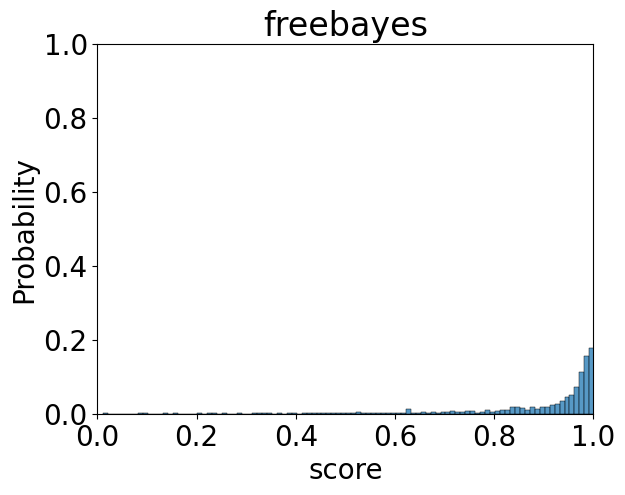

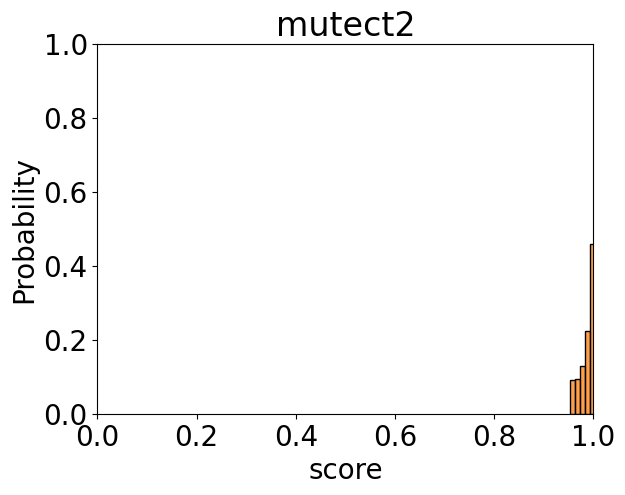

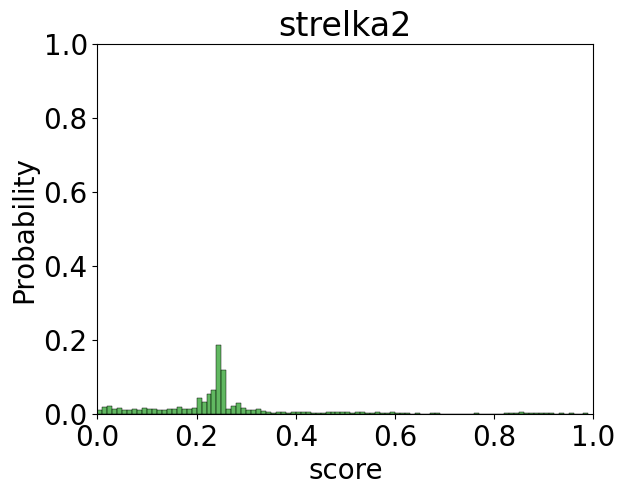

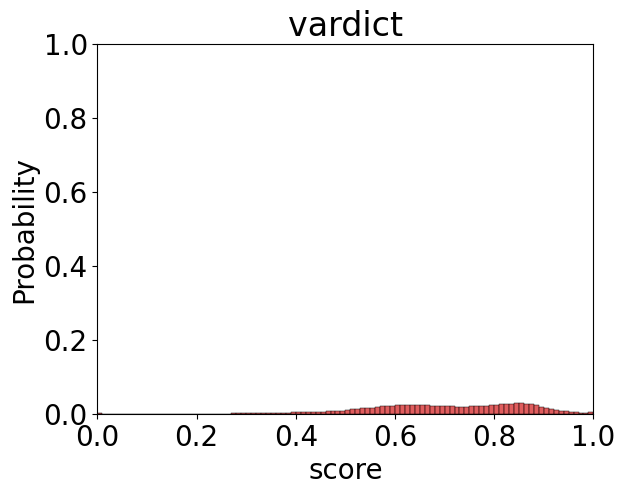

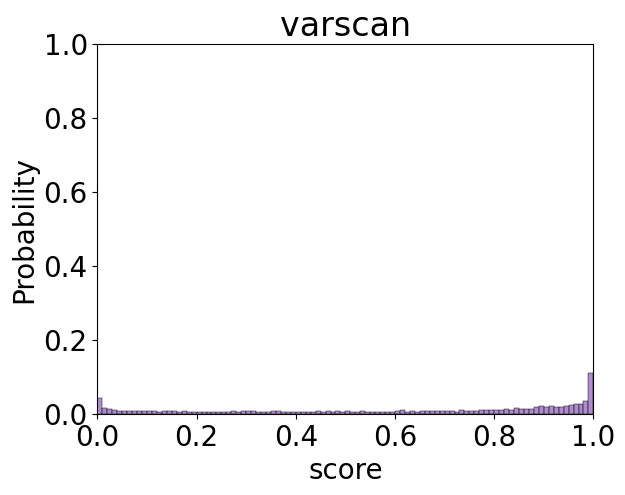

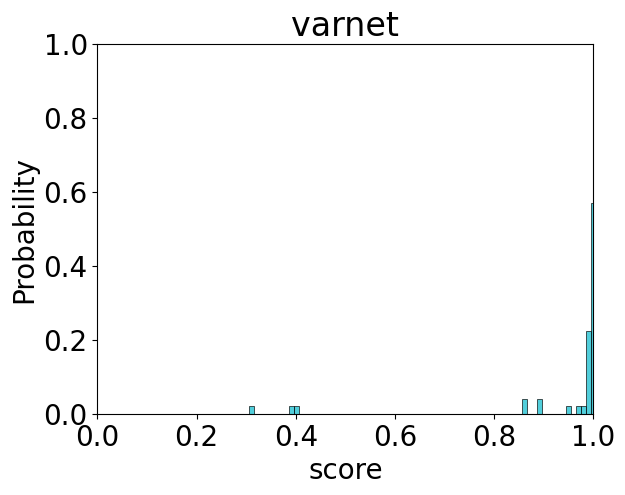

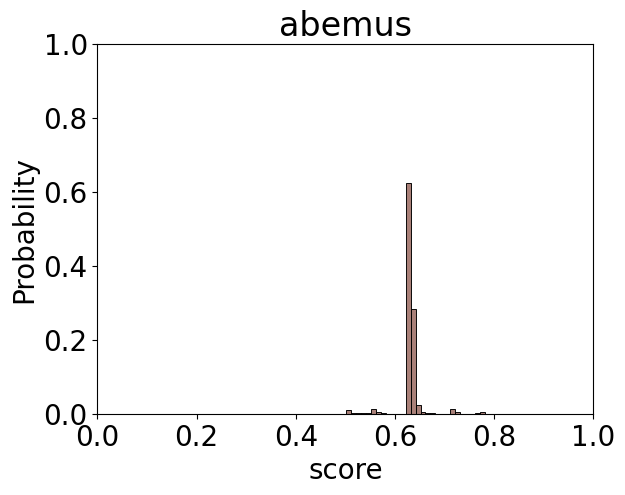

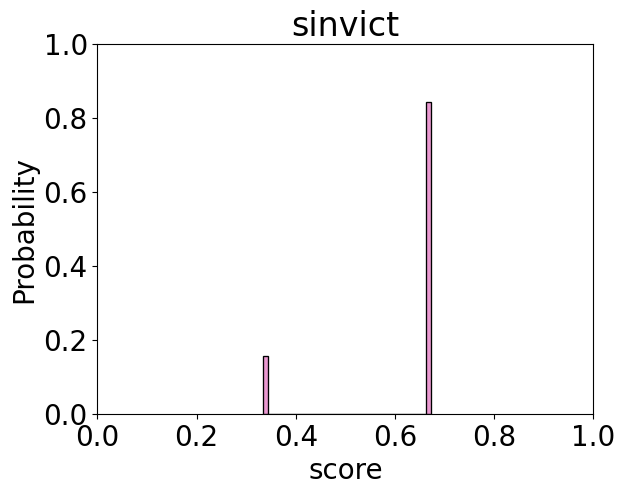

In [162]:
calltablesseries = pd.read_csv(os.path.join('data', 'mixtures', 'mixtures_allchr', 'BRA-412_240820-CW-T_BRA-412_060220-CW-T_snv_calls_all.csv'), index_col=0)
aux = pd.read_csv(os.path.join('data', 'mixtures', 'mixtures_allchr', 'BRA-412_240820-CW-T_BRA-412_060220-CW-T_tf_cov.csv'),index_col=0)
gtm = 5
muttype = 'snv'
refsample = 'undiluted'
fixedvar = 'coverage'
#fixedvar = 'ctdna'
if fixedvar == 'coverage':
    seriesorder = [(100, 0), (70, 30), (50, 50), (30, 70), (20, 80), (10, 90)]
    xaxis = 'tumor burden'
elif fixedvar == 'ctdna':
    seriesorder = [(100, 0), (100, 50), (100, 100)]
    xaxis = 'coverage'
dilutionseries = aux.T[['mixture_' + '_'.join(mixtureid.split('_')[:2]) + '_' + str(s[0]) + 'x_' + '_'.join(mixtureid.split('_')[2:4]) + '_' + str(s[1]) + 'x' for s in seriesorder]].T
calltablesseries = generate_groundtruth(config, calltablesseries, aux['tf'], ground_truth_method=gtm, muttype=muttype,
                                        matchedtissuepath=None, methods=['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'varnet', 'abemus', 'sinvict'])

In [168]:
for tfv in dilutionseries['tf'].values[:]:
    calltablesseries['{:.2f}_median_vaf'.format(tfv)] = calltablesseries[['{:.2f}_{}_vaf'.format(tfv, m) for m in config.methods]].median(axis=1, skipna=True)

986


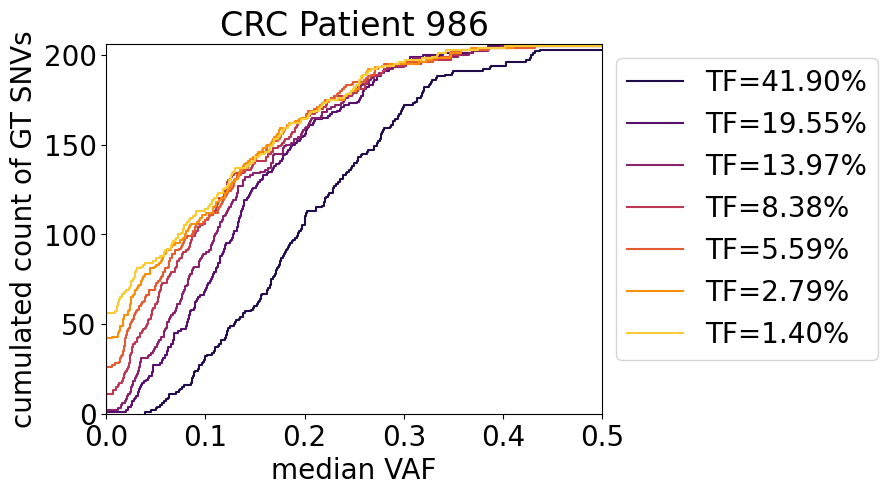

In [169]:
# cumlated vaf plots
patient = mixtureid.split('-')[1].split('_')[0]
print(patient)
colors = sns.color_palette('inferno', n_colors=7).as_hex()
calltablesseries_true = calltablesseries[calltablesseries['truth'] == True]
fig, ax = plt.subplots()
for tfvi, tfv in enumerate(dilutionseries['tf'].values[:]):
    if tfv == 21.2106 and patient == '1014':
        print('hello')
        A = pd.read_csv('/Users/hanae/Repositories/cfdna_snv_benchmark/data/mixtures/mixtures_chr8/mixtures_chr8_CRC-1014_180816-CW-T_CRC-1014_090516-CW-T/mixture_chr8_CRC-1014_180816-CW-T_70x_CRC-1014_090516-CW-T_80x/calls/mixture_chr8_CRC-1014_180816-CW-T_70x_CRC-1014_090516-CW-T_80x_snv_calls_all.csv', index_col=0)
        B = A.loc[keepids]
        B['median_vaf'] = B[[m+'_vaf' for m in config.methods]].median(axis=1, skipna=True)
        calltablesseries_true.loc[B.index, '{:.2f}_median_vaf'.format(tfv)] = B['median_vaf']
    sns.ecdfplot(calltablesseries_true['{:.2f}_median_vaf'.format(tfv)].fillna(0), label='TF={:.2f}%'.format(tfv), ax=ax, color=colors[tfvi], stat='count')
    #medianval = calltablesseries_true['{:.2f}_median_vaf'.format(tfv)].fillna(0)
    #medianval = medianval.median()
    #print(tfv, medianval)
    #plt.vlines(x=medianval, ymin=0, ymax=0.5, ls='--', lw=1, color=colors[tfvi])
    #plt.hlines(y=0.5, xmin=0, xmax=medianval, ls='--', lw=1, color=colors[tfvi])
ax.set_xlim(0,0.5)
plt.xlabel('median VAF')
plt.ylabel('cumulated count of GT SNVs')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title('CRC Patient '+patient)
plt.savefig('figures/supplfigure_cumulatedvaf/cumulatedvaf_'+patient+'.svg', bbox_inches='tight')
plt.savefig('figures/supplfigure_cumulatedvaf/cumulatedvaf_'+patient+'.png', bbox_inches='tight')

In [151]:
calltablesseries_true['{:.2f}_median_vaf'.format(tfv)].fillna(0)

In [153]:
medianval.median()

0.06894796380090495